In [14]:
import requests
import json
import lxml.html as lh
import pandas as pd

from bs4 import BeautifulSoup as bs

In [22]:
ft_url = 'http://markets.ft.com'

In [49]:
# Quesry FT symbol by ISIN on web

def query_ft_ticker( isin_ticker ):
    
    r = requests.get( ft_url + '/data/search', params = {'query':isin_ticker})
    
    if r.status_code == requests.codes.ok:
        soup = bs(r.text, "html.parser")
        tb = soup.find('table', class_='mod-ui-table mod-ui-table--freeze-pane')      
        tr = tb.findAll('tr')
                
        if len(tr)!= 1:
            return
        
        td = tr[0].find('td')
        href = td.find('a').get('href')
        name = td.text
        
        print(href)
        print(name)
        
        td = td.find_next_sibling()
        symbol = td.text
        print(symbol)
    
        r = requests.get( ft_url + href )
        if r.status_code == requests.codes.ok:
            soup = bs(r.text, "html.parser")
            k = soup.find('section', class_='mod-tearsheet-add-to-portfolio')
            js = json.loads(str(k.get('data-mod-config')))
            
            xid = js['xid']
            print(xid)
    
            return xid
    return

In [19]:
# Get Fund historical prices from markets.ft.com

def get_historical_prices( isin_ticker, fromDate='2018/01/01', toDate='2018/11/27' ):   
    
    q_params = {'startDate': fromDate,
                'endDate': toDate,
                'symbol': query_ft_ticker(isin_ticker)}

    # Download the result from website
    r = requests.get( ft_url + '/data/equities/ajax/get-historical-prices', params = q_params)
   
    # Check if it is ok
    if r.status_code == requests.codes.ok:

        # Prepare table and headers
        headers = ["Date", "Open", "High", "Low", "Close", "Volume"]
        col = []
        for h in headers:
            col.append((h,[]))

        #Store the contents of the website under doc
        doc = lh.fromstring(r.json()['html'])
    
        #Parse data that are stored between <tr>..</tr> of HTML
        tr_elements = doc.xpath('//tr')
    
        #Since out first row is the header, data is stored on the second row onwards
        for e in tr_elements:
    
            #If row is not of size 6, the //tr data is not from our table 
            if len(e)!=6:
                break
    
            #i is the index of our column
            i=0
    
            #Iterate through each element of the row
            for t in e.iterchildren():
         
                if i==0:
                    data=t[1].text_content()
                else:
                    data=t.text_content() 
                
                #Append the data to the empty list of the i'th column
                col[i][1].append(data)
        
                #Increment i for the next column
                i+=1

        return {title:column for (title,column) in col}   


In [47]:
df = pd.DataFrame(get_historical_prices('LU0441901922',fromDate='2017/01/01',toDate='2017/12/31'))

df['Date'] = pd.to_datetime(df['Date'])
df['Open'] = pd.to_numeric(df['Open'])
df['High'] = pd.to_numeric(df['High'])
df['Low'] = pd.to_numeric(df['Low'])
df['Close'] = pd.to_numeric(df['Close'])

/data/funds/tearsheet/summary?s=LU0441901922:USD
Templeton Emerging Markets Bond Fund A(Mdis)USD
LU0441901922:USD
28272251


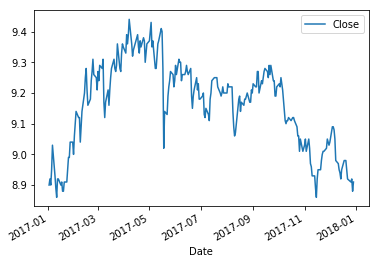

In [48]:
df.plot(x='Date',y='Close')